In [5]:
import utils.plot_utils 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Loading data

Great options to explore are: 
- Adding a random flip to the TRAIN images
- Adding a random rotation to the TRAIN images
- Randomly cropping the TRAIN images

In [7]:
transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

train_dataset = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)

Files already downloaded and verified


In [8]:
def train(model, device, train_loader, optimizer, epoch, log_every=300):
    model.train()
    losses = list()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_every == 0:
            losses.append(loss.item())
    return losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv = nn.Conv2d(3, 5, kernel_size=5)
        self.fc = nn.Linear(980, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv(x), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return F.log_softmax(x, dim=1)
    

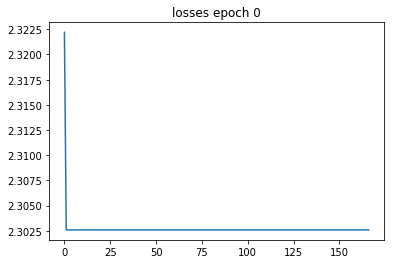


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10%)



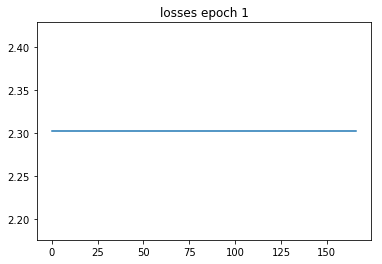


Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10%)



KeyboardInterrupt: 

In [17]:
BATCH_SIZE=64
TEST_BATCH_SIZE=64
EPOCHS=10
LEARNING_RATE=0.01

model = Network().to(device)
optimizer = optim.Adam(model.parameters()) # Feel free to use a different optimizer

for epoch in range(EPOCHS):
    losses = train(model, device, train_loader, optimizer, epoch)
    utils.plot_utils.plot_loss(losses, epoch)
    test(model, device, test_loader)
